<a href="https://colab.research.google.com/github/hr1588/NLP/blob/main/chapter_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers 
from install import *
install_requirements(chapter=7)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 588 (delta 5), reused 3 (delta 1), pack-reused 569
Receiving objects: 100% (588/588), 57.41 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.6.1
Using datasets v1.11.0
Using haystack


In [2]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [3]:
# haystack의 로깅을 끕니다.
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
               "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
               "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# 리뷰 기반 QA 시스템 구축

## 데이터셋 로드

In [4]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names('subjqa')
domains

Downloading:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [5]:
from datasets import load_dataset

subjqa = load_dataset('subjqa', name = 'electronics') # 전자제품용 QA
print(subjqa['train'][1])

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.
{'domain': 'electronics', 'nn_mod': 'harsh', 'nn_asp': 'high', 'query_mod': 'not
strong', 'query_asp': 'bass', 'q_reviews_id':
'7c46670208f7bf5497480fbdbb44561a', 'question_subj_level': 1, 'ques_subj_score':
0.5, 'is_ques_subjective': False, 'review_id':
'ce76793f036494eabe07b33a9a67288a', 'id': 'd476830bf9282e2b9033e2bb44bbb995',
'title': 'B00001P4ZH', 'context': 'To anyone who hasn\'t tried all the various
types of headphones, it is important to remember exactly what these are: cheap
portable on-ear headphones. They give a totally different sound then in-ears or
closed design phones, but for what they are I would say they\'re good. I
currently own six pairs of phones, from stock apple earbuds to Sennheiser HD
518s. Gave my Portapros a run on both my computer\'s sound card and mp3 p

In [6]:
print(subjqa['train']['answers'][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


In [7]:
import pandas as pd

dfs = {split : dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}에 있는 질문 개수 : {df['id'].nunique()}")

train에 있는 질문 개수 : 1295
test에 있는 질문 개수 : 358
validation에 있는 질문 개수 : 255


In [8]:
dfs['train'][0:1]

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.5,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4AA and QZ-99. The Koss Portapr...",How is the bass?,[],[],[],[],[]


In [9]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"] # 지정된 항목만 추출

sample_df = dfs['train'][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


In [10]:
start_idx = sample_df['answers.answer_start'].iloc[0][0]
end_idx = start_idx+len(sample_df['answers.text'].iloc[0][0])
sample_df['context'].iloc[0][start_idx:end_idx] # 리뷰에서 답변에 해당하는 내용 추출

'this keyboard is compact'

## TRAIN에 어떤 종류의 질문이 있는지 확인

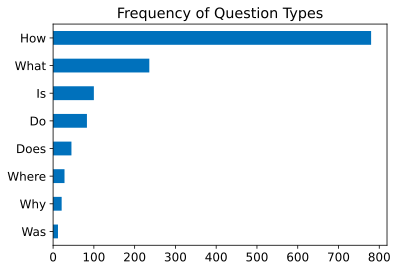

In [11]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs['train']['question'].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [12]:
for type in question_types[0:3]:
    for q in (dfs['train'][dfs['train'].question.str.startswith(type)].sample(n=3, random_state = 42)['question']):
        print(q)

What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
How is the camera?
How do you like the control?
How fast is the charger?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## 텍스트에서 정답 추출

In [13]:
from transformers import AutoTokenizer

model_ckpt = 'deepset/minilm-uncased-squad2'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

In [14]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""

inputs = tokenizer(question, context, return_tensors = 'pt')

In [15]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient = 'index')
input_df 
# token_type_ids : 0은 질문 토큰, 1은 문맥 토큰

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [16]:
print(tokenizer.decode(inputs['input_ids'][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


In [17]:
from transformers.models.auto.modeling_auto import AutoModelForTableQuestionAnswering
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Downloading:   0%|          | 0.00/133M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


In [18]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


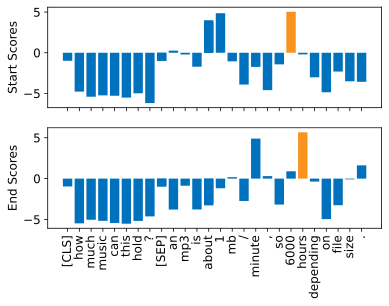

In [19]:
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex = True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height = s_scores, color = colors)
ax1.set_ylabel('Start Scores')

colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height = e_scores, color = colors)
ax2.set_ylabel('End Scores')

plt.xticks(rotation="vertical")
plt.show()

In [20]:
import torch 

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs['input_ids'][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"질문 : {question}")
print(f"답변: {answer}")

질문 : How much music can this hold?
답변: 6000 hours


In [21]:
from transformers import pipeline

pipe = pipeline("question-answering", model = model, tokenizer = tokenizer)
pipe(question = question, context = context, topk = 3)
 # topk : 모델이 여러개의 답을 예측
 # score : 답변 이외 logit에 softmax를 적용해 모델이 추정한 확률 

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/question_answering.py:316: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  fw_args = {k: torch.tensor(v, device=self.device) for (k, v) in fw_args.items()}


[{'score': 0.26516079902648926,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22083008289337158,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253581404685974,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [22]:
pipe(question = "Why is there no data?", context = context, handle_impossible_answer = True)
# answers.answer_start가 비어 있는, 즉 답이 없는 경우 CLS 토큰에 점수를 할당, 출력을 빈 문자열로 mapping

{'score': 0.9068412780761719, 'start': 0, 'end': 0, 'answer': ''}

In [23]:
pipe(question = "Why is there no data?", context = context, handle_impossible_answer = False)

{'score': 0.0002626474597491324,
 'start': 16,
 'end': 71,
 'answer': '1 MB/minute, so about 6000 hours depending on file size'}

## 긴 텍스트 다루기

In [24]:
def compute_input_length(row):
    inputs = tokenizer(row['question'], row['context'])
    return len(inputs['input_ids'])

dfs['train']['n_tokens'] = dfs['train'].apply(compute_input_length, axis = 1)

In [25]:
dfs['train'][0:1]

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective,n_tokens
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.5,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4AA and QZ-99. The Koss Portapr...",How is the bass?,[],[],[],[],[],155


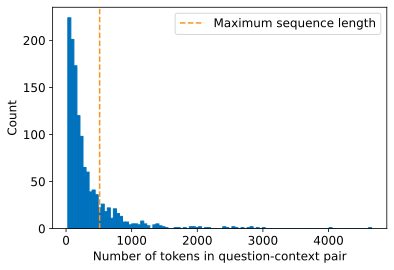

In [26]:
fig, ax = plt.subplots()

dfs['train']['n_tokens'].hist(bins = 100, grid = False, ec = 'C0', ax = ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin = 0, ymax = 1, linestyle = "--", color = "C1",
           label = "Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

In [27]:
example = dfs['train'].iloc[0][['question','context']]
tokenized_example = tokenizer(example['question'], example['context'],
                              return_overflowing_tokens = True, max_length = 100, stride = 25)
# 슬라이딩 윈도의 크기 : max_length, stride의 크기 : doc_stride

In [28]:
tokenized_example 

{'input_ids': [[101, 2129, 2003, 1996, 3321, 1029, 102, 1045, 2031, 2018, 12849, 4757, 2132, 19093, 1999, 1996, 2627, 1010, 4013, 26424, 2050, 1998, 1053, 2480, 1011, 5585, 1012, 1996, 12849, 4757, 3417, 9331, 3217, 2003, 12109, 1998, 2038, 2307, 3321, 3433, 1012, 1996, 2147, 2307, 2007, 2026, 11924, 3042, 1998, 2064, 2022, 1000, 4565, 2039, 1000, 2000, 2022, 3344, 1999, 2026, 9055, 6598, 2030, 3274, 4524, 2302, 2893, 24514, 2098, 1012, 2027, 2024, 2200, 2422, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 102], [101, 2129, 2003, 1996, 3321, 1029, 102, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 2305, 1998, 2154, 2488, 2084, 2151, 4540, 1011, 13007, 2071, 2022, 1998, 2024, 2471, 2004, 2204, 2004, 1996, 4013, 26424, 2050, 1012, 2027, 2024, 1000, 2330, 2250, 1000, 2132, 19093, 2061,

In [29]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


In [30]:
for window in tokenized_example['input_ids']:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and don't feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even
after listening to music with them on all day. the sound is night and day better
than any ear - bud could be and are almost as good as the pro 4aa. they are "
open air " headphones so you cannot match the bass to the sealed types, but it
comes close. for $ 32, you cannot go wrong. [SEP]



# haystack을 사용해 QA pipeline 구축

## 문서 저장소 초기화

### 일래스틱서치 다운

In [31]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.3-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.3-linux-x86_64.tar.gz

In [32]:
import os
from subprocess import Popen, PIPE, STDOUT

# 백그라운드 프로세스(chown)로 일래스틱서치를 실행(Popen)합니다
!chown -R daemon:daemon elasticsearch-7.9.3
es_server = Popen(args=['elasticsearch-7.9.3/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# 일래스틱서치가 시작할 때까지 기다립니다
!sleep 30

In [33]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "8f10b859d3ae",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "A1ayG93URySuXvnTy8DH-A",
  "version" : {
    "number" : "7.9.3",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "c4138e51121ef06a6404866cddc601906fe5c868",
    "build_date" : "2020-10-16T10:36:16.141335Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [34]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore

# 밀집 리트리버에서 사용할 문서 임베딩을 반환합니다.
document_store = ElasticsearchDocumentStore(return_embedding=True)
# 일래스틱서치에 2개의 index 제작(문서 - document, 답의 범위 - label)

In [35]:
# 노트북을 다시 시작할 때 일래스틱서치 저장소를 모두 비우는 것이 좋습니다.
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [36]:
for split, df in dfs.items():
    # 중복 리뷰 제외
    docs = [{'text' : row['context'],
             "meta" : {"item_id" : row['title'], 'question_id':row['id'],'split':split}}
            for _,row in df.drop_duplicates(subset = 'context').iterrows()]
    document_store.write_documents(docs, index = 'document')

print(f"{document_store.get_document_count()}개 문서가 저장되었습니다.")

1615개 문서가 저장되었습니다.


## 리트리버 초기화

- 쿼리에서 관련된 문서를 추출

In [37]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)
# TF-IDF를 개선한 버전으로, 일래스틱서치에서 효율적으로 검색할 수 있는 희소 벡터로 질문과 문맥 표현

In [38]:
item_id = "B0074BW614" # 아마존 파이어 태블릿
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

# top_k : 얼마나 많은 문서를 반환할지 결정
# meta 필드에 필터를 적
# retrieved_docs의 각 원소는 문서를 나타내는 데 사용하는 해이스택의 document 객체
# 리트리버의 쿼리 점수와 그 외 메타데이터를 포함

In [39]:
print(retrieved_docs[0])

{'text': 'This is a gift to myself.  I have been a kindle user for 4 years and
this is my third one.  I never thought I would want a fire for I mainly use it
for book reading.  I decided to try the fire for when I travel I take my laptop,
my phone and my iPod classic.  I love my iPod but watching movies on the plane
with it can be challenging because it is so small. Laptops battery life is not
as good as the Kindle.  So the Fire combines for me what I needed all three to
do. So far so good.', 'score': 6.243799, 'probability': 0.6857824513476455,
'question': None, 'meta': {'item_id': 'B0074BW614', 'question_id':
'868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'embedding': None, 'id':
'252e83e25d52df7311d597dc89eef9f6'}


## 리더 초기화

- 해이스택에는 두 종류의 리더가 존재(FARMReader, TransformerReader)

### FARMReader

In [40]:
!pip install torch --upgrade # mps error 발생시 사용

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 12.3 MB/s eta 0:00:00
     ━━━━━

In [41]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

In [42]:
print(reader.predict_on_texts(question = question, texts = [context], top_k = 1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.64809501171112,
'answers': [{'answer': '6000 hours', 'score': 10.699626922607422, 'probability':
0.3988155424594879, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offset_start': 38, 'offset_end': 48,
'offset_start_in_doc': 38, 'offset_end_in_doc': 48, 'document_id':
'e344757014e804eff50faa3ecf1c9c75'}]}


- 'no_ans_gap'은 FARM(Fast Adaptive Representation Mining) 판독기에서 추론 중 최상의 답변과 차선의 답변 사이에 허용되는 최대 간격을 지정하는 매개 변수입니다.

- nFARM 판독기를 질문 답변 작업에 사용할 때는 상황에 따라 주어진 질문에 대한 최상의 답변을 예측합니다. 그러나 경우에 따라 모형이 하나의 답변을 제공하기에 충분히 신뢰하지 못할 수 있으며 다양한 신뢰 점수를 가진 여러 답변을 제공할 수 있습니다. 이러한 경우 'no_ans_gap' 매개 변수를 사용하여 정답을 유효한 것으로 간주하기 위한 임계값을 제어할 수 있습니다.

- 상위 두 답변의 신뢰 점수 차이가 'no_ans_gap'보다 작거나 같으면 모형은 해당 답변이 유효하지 않은 것으로 간주하고 "no-ans_gap" 응답을 반환합니다. 반면 상위 두 답변의 신뢰 점수 차이가 'no_ans_gap'보다 크면 모형은 상위 답변을 유효한 것으로 간주하고 예측된 답변으로 반환합니다.

- 'no_ans_gap'에 값을 높게 설정하면 모형이 더 보수적이고 신뢰할 수 없을 때 답을 예측할 가능성이 감소하는 반면, 값을 낮게 설정하면 모형이 더 공격적이고 신뢰할 수 없는 경우에도 답을 예측할 가능성이 더 높아집니다.

## 리트리버와 리더를 결합(pipeline)

In [43]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [44]:
n_answers = 3

preds = pipe.run(query = query, top_k_retriever = 3, top_k_reader = n_answers,
                 filters = {"item_id": [item_id], "split":["train"]})

In [45]:
preds

{'query': 'Is it good for reading?',
 'no_ans_gap': 13.715803742408752,
 'answers': [{'answer': 'I mainly use it for book reading',
   'score': 12.282354354858398,
   'probability': 0.341878205537796,
   'context': ' is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la',
   'offset_start': 59,
   'offset_end': 91,
   'offset_start_in_doc': 132,
   'offset_end_in_doc': 164,
   'document_id': '252e83e25d52df7311d597dc89eef9f6',
   'meta': {'item_id': 'B0074BW614',
    'question_id': '868e311275e26dbafe5af70774a300f3',
    'split': 'train'}},
  {'answer': 'the larger screen compared to the Kindle makes for easier reading',
   'score': 12.188583374023438,
   'probability': 0.3416520655155182,
   'context': 'ght enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the color, something I never thou',
   'offset_start': 43,
   'offset_end

In [49]:
print(f"질문: {preds['query']} \n")
for idx in range(n_answers):
    print(f"답변 {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"해당 리뷰 텍스트: ...{preds['answers'][idx]['context']}...")
    print("\n\n")

질문: Is it good for reading?

답변 1: I mainly use it for book reading
해당 리뷰 텍스트: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



답변 2: the larger screen compared to the Kindle makes for easier reading
해당 리뷰 텍스트: ...ght enough that I can hold it to read, but the larger screen
compared to the Kindle makes for easier reading. I love the color, something I
never thou...



답변 3: it is great for reading books when no light is available
해당 리뷰 텍스트: ...ecoming addicted to hers! Our son LOVES it and it is great for
reading books when no light is available. Amazing sound but I suggest good
headphones t...





# QA pipeline 개선

## 리트리버 평가

In [60]:
dfs['test'][0:1]

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,electronics,comparable,quality,perfect,balance,aa99f9b7fe9fe9c921bc2f963cb22121,1,0.0,False,f011c75fb8d26066217e64b3ff470d84,d0781d13200014aa25860e44da9d5ea7,B00001WRSJ,I have been a headphone fanatic for thirty years and have owned and used a v...,What is the tonal balance of these headphones?,[I have been a headphone fanatic for thirty years],[0],[1],[0.8],[True]


In [50]:
from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(component = self.retriever, name = "ESRetriever",
                      inputs = ['Query']) 
        # Query는 검색을 수행하기 위해 사용자가 입력하는 검색어. 검색 시스템에서는 이 검색어를 이용하여 적절한 검색 결과를 찾아냄
        pipe.add_node(component = self.eval_retriever, name = "EvalRetriever", inputs = ['ESRetriever'])
        # EvalRetriever 노드에서는 찾아낸 검색 결과를 평가하여 검색 성능을 측정
        self.pipeline = pipe

pipe = EvalRetrieverPipeline(es_retriever)

In [57]:
from haystack import Label

labels = []

for i,row in dfs['test'].iterrows():
    # 리트리버에서 필터링을 위해 사용하는 메타데이터
    meta = {'item_id': row['title'], 'question_id':row['id']}
    # 답이 있는 질문을 레이블에 추가
    if len(row['answers.text']):
        for answer in row['answers.text']:
            label = Label(question = row['question'], answer = answer, id = i, origin = row['id'],
                          meta = meta, is_correct_answer = True, is_correct_document= True, no_answer = False)
            labels.append(label)
    # 답이 없는 질문을 레이블에 추가
    else:
        label = Label(question = row['question'], answer = "", id = i, origin = row['id'],
                      meta = meta, is_correct_answer = True, is_correct_document= True, no_answer = True)
        labels.append(label)

In [58]:
print(labels[0])

# 'created_at'와 'updated_at'은 해당 레이블이 생성된 시간과 업데이트된 시간을 나타내는 필드
# 이 레이블 객체를 생성할 때 이 두 필드를 명시적으로 설정하지 않았기 때문에, None으로 설정된 것

{'id': '52f8fbd0-3435-4312-966a-933a3128b025', 'created_at': None, 'updated_at':
None, 'question': 'What is the tonal balance of these headphones?', 'answer': 'I
have been a headphone fanatic for thirty years', 'is_correct_answer': True,
'is_correct_document': True, 'origin': 'd0781d13200014aa25860e44da9d5ea7',
'document_id': None, 'offset_start_in_doc': None, 'no_answer': False,
'model_id': None, 'meta': {'item_id': 'B00001WRSJ', 'question_id':
'd0781d13200014aa25860e44da9d5ea7'}}


In [61]:
document_store.write_labels(labels, index = 'label') # labels 리스트에 담긴 Label 객체들을 'label' 인덱스에 저장
print(f"""{document_store.get_label_count(index="label")}개의 질문 답변 쌍을 로드했습니다.""")

358개의 질문 답변 쌍을 로드했습니다.


In [63]:
labels_agg = document_store.get_all_labels_aggregated( 
    index = 'label',
    open_domain = True,
    aggregate_by_meta = ['item_id']
)

print(len(labels_agg)) 
# 고유 ID를 가진 모든 질문-답변 쌍을 가져옴, MultiLable 객체의 list 반환
# 위의 질문 답변 쌍과 개수가 다른 이유는 item_id가 중복되지 않는 레이블들만 포함, 즉 같은 item_id를 가지는 레이블들을 하나로 집계했기 때문

330


In [65]:
print(labels_agg[0])

{'question': 'What is the tonal balance of these headphones?',
'multiple_answers': ['I have been a headphone fanatic for thirty years'],
'is_correct_answer': True, 'is_correct_document': True, 'origin':
'd0781d13200014aa25860e44da9d5ea7', 'multiple_document_ids': [None],
'multiple_offset_start_in_docs': [None], 'no_answer': False, 'model_id': None,
'meta': {'item_id': 'B00001WRSJ'}}


- top_k_retriever : 검색 모델에서 상위 k개의 검색 결과를 선택. 검색 모델은 주어진 쿼리와 일치하는 문서를 검색하여 추출된 문서들 중에서 top-k개를 선택

- top_k_reader : 추론 모델에서 상위 k개의 후보 답변을 선택. 추론 모델은 주어진 문서와 질문 쌍을 처리하여 가능성 있는 답변 후보군을 생성하고, 이 중에서 가장 가능성이 높은 top-k개의 답변을 선택

- 상위 k개의 후보군을 선택하는 것은 모델 성능을 높이기 위한 기법 중 하나로, 선택된 후보군들 중에서 정답이 있을 가능성이 높은 것을 모델이 선택하도록 하여 정확도를 높일 수 있음

In [66]:
def run_pipeline(pipeline, top_k_retriever = 10, top_k_reader = 4): # 인자 기본값 설정
    for i in labels_agg:
        _ = pipeline.pipeline.run(
            query = i.question,
            top_k_retriever = top_k_retriever,
            top_k_reader = top_k_reader,
            top_k_eval_documents = top_k_retriever, # 평가 데이터셋에서 검색 후 평가해야 할 문서 수를 제한
            labels = i,
            filters = {"item_id":[i.meta['item_id']], 'split':['test']}
        )

In [68]:
run_pipeline(pipe, top_k_retriever = 3)
print(f"재현율@3 : {pipe.eval_retriever.recall:.2f}") # 소수점 이하 2자리까지 출력

재현율@3 : 0.95


In [69]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}

    for topk in topk_values :
        # 파이프라인 제작
        p = EvalRetrieverPipeline(retriever)
        # 테스트 세트에 있는 질문-답변 쌍을 반복
        run_pipeline(p, top_k_retriever = topk)
        # 재현율 저장
        topk_results[topk] = {"recall": p.eval_retriever.recall}
    
    return pd.DataFrame.from_dict(topk_results, orient = 'index')

In [70]:
es_topk_df = evaluate_retriever(es_retriever)
es_topk_df

,recall
1,0.890909
3,0.954545
5,0.981818
10,0.990909
20,0.990909


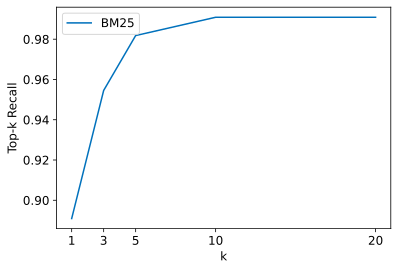

In [74]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([es_topk_df], ["BM25"])

## DPR

In [75]:
 from haystack.retriever.dense import DensePassageRetriever

 dpr_retriever = DensePassageRetriever(document_store = document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

- document_store : 문서 검색을 위해 필요한 문서들을 저장하는 데이터베이스나 저장소를 나타내는 객체

- DensePassageRetriever : 밀집 임베딩(dense embeddings)을 사용하여 대규모 문서들로부터 적절한 단락(passage)들을 검색하고 순위를 매기는 검색 모델, 주어진 검색어에 대해 가장 관련성이 높은 단락들을 검색하는 역할 

In [76]:
document_store.update_embeddings(retriever = dpr_retriever)

Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

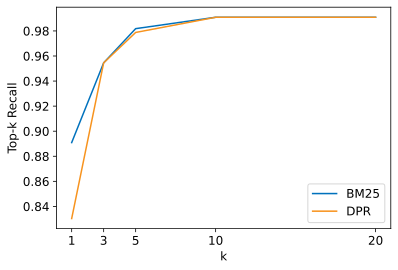

In [78]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([es_topk_df, dpr_topk_df], ['BM25', 'DPR']) 
# DPR은 recall이 BM25보다 높지않고, k=3에서 비슷하게 수렴

## 리더 평가